In [17]:
import numpy as np
import scipy.stats as sps
import os
import csv
import matplotlib.pyplot as plt
from scipy.stats import skewtest, skew, kurtosis, kurtosistest
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
currentdir = os.getcwd()
datadir = os.path.join(currentdir,'OxytocinRSData_new')
print(datadir)

/Users/hstrey/Documents/programming/fMRI-analysis/OxytocinRSData_new


In [3]:
# get data files names
datafilenames = os.listdir(datadir)
print(datafilenames)

['Subject002.npy', 'Subject003.npy', 'Subject001.npy', 'Subject004.npy', 'Subject005.npy', 'results.csv']


In [4]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult(x1,0.802)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult(x2,0.802)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)

In [5]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

def hessian(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    return np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])

In [47]:
def corrOU(y1,y2,delta_t):
    x1 = y1+y2
    x2 = y1-y2
    N = len(x1)
    rho = sps.pearsonr(x1,x2)[0]
    c = 2*rho/(1-rho)
    guessa1 = 1.0
    guessa2 = 1.0/(1.0+c)
    guessd = 1.0
    a1ep,a1ss,a1c = calc_fundstats(x1)
    a2ep,a2ss,a2c = calc_fundstats(x2)
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],jac=hessian,args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    h = hessian([A1,A2,D],a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    var = -np.linalg.inv(h)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    return A1,dA1,A2,dA2,D,dD,C,dC,tau1,dtau1,tau2,dtau2

mean MPFC:  -5.0998628e-09
var:  1.000000476837215
N:  748
relaxation time: 6.303452036864351 SD tau 0.9664160564041558
A  0.9921413761036094 SD A 0.1429234278901148
mean PCC:  7.649794e-09
var:  1.0
relaxation time: 7.217649153672873 SD tau 1.1838541637882665
A  1.0062769259605675 SD A 0.15611971630909358
mean RLP:  -5.7373453e-09
var:  1.0000002384185933
relaxation time: 7.295618221484745 SD tau 1.2097079756582125
A  1.0163723874782427 SD A 0.15939209587816294
mean LLP:  -7.649794e-09
var:  0.9999996423721633
relaxation time: 5.16055971048208 SD tau 0.7357751230745184
A  1.0098735194946864 SD A 0.13325862844354566
mean MPFC:  7.012311e-09
var:  1.0
N:  748
relaxation time: 4.951798624556315 SD tau 0.7158666195196934
A  1.0555732603661954 SD A 0.14011353256241396
mean PCC:  1.2749657e-09
var:  1.0
relaxation time: 7.989069847219934 SD tau 1.3656366756565408
A  1.0009735825910855 SD A 0.16274570699835292
mean RLP:  -1.5299587e-08
var:  1.0000002384185933
relaxation time: 5.685660149842

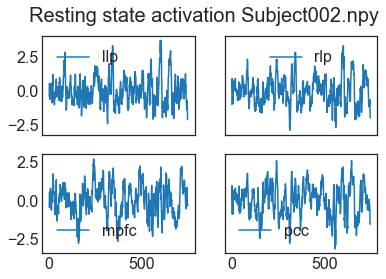

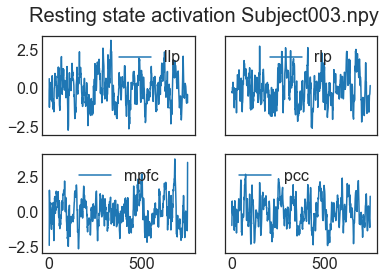

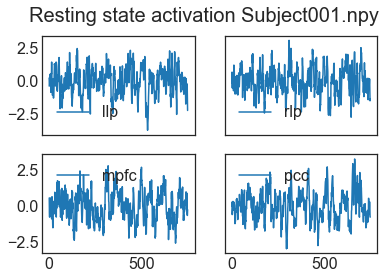

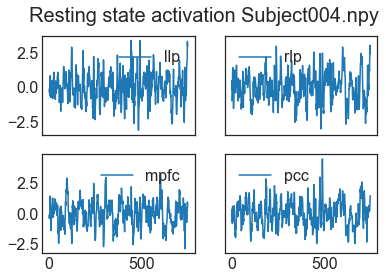

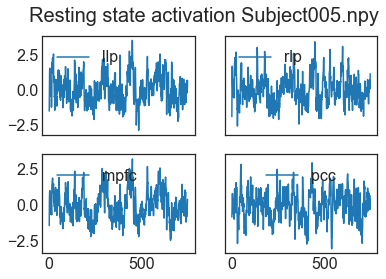

In [29]:
results = None
for datafilename in datafilenames:
    if datafilename.endswith('.npy'):
        time_series = np.load(os.path.join(datadir,datafilename),allow_pickle=True)
    else:
        continue
    mpfc = time_series[:,0]
    llp = time_series[:,1]
    rlp = time_series[:,2]
    pcc = time_series[:,3]
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    f.suptitle('Resting state activation '+datafilename)
    ax1.plot(llp, label="llp")
    ax1.legend()
    ax2.plot(rlp,label = "rlp")
    ax2.legend()
    ax3.plot(mpfc,label = "mpfc")
    ax3.legend()
    ax4.plot(pcc,label = "pcc")
    ax4.legend()
    
    print("mean MPFC: ",mpfc.mean())
    print("var: ",mpfc.std()**2)
    N=len(mpfc)
    print("N: ",N)
    mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc,0.802)
    print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
    print("A ",mpfc_A,"SD A",mpfc_sA)
    mpfc_norm=mpfc/np.sqrt(mpfc_A)
    t = np.arange(N)*0.802 # tR = 0.802 sec

    print("mean PCC: ",pcc.mean())
    print("var: ",pcc.std()**2)
    pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc,0.802)
    print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
    print("A ",pcc_A,"SD A",pcc_sA)
    pcc_norm=pcc/np.sqrt(pcc_A)
    
    print("mean RLP: ",rlp.mean())
    print("var: ",rlp.std()**2)
    rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp,0.802)
    print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
    print("A ",rlp_A,"SD A",rlp_sA)
    rlp_norm=rlp/np.sqrt(rlp_A)
    
    print("mean LLP: ",llp.mean())
    print("var: ",llp.std()**2)
    llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp,0.802)
    print("relaxation time:",llp_tau, "SD tau", llp_dtau)
    print("A ",llp_A,"SD A",llp_sA)
    llp_norm=llp/np.sqrt(llp_A)
    
    mpfc_pcc,mpfc_pcc_sd = OUcross(mpfc_norm,pcc_norm)
    mpfc_rlp,mpfc_rlp_sd = OUcross(mpfc_norm,rlp_norm)
    mpfc_llp,mpfc_llp_sd = OUcross(mpfc_norm,llp_norm)
    pcc_rlp,pcc_rlp_sd = OUcross(pcc_norm,rlp_norm)
    pcc_llp,pcc_llp_sd = OUcross(pcc_norm,llp_norm)
    rlp_llp,rlp_llp_sd = OUcross(rlp_norm,llp_norm)
    
    mpfc_pcc_pc,mpfc_pcc_pv = sps.pearsonr(mpfc_norm,pcc_norm)
    mpfc_rlp_pc,mpfc_rlp_pv = sps.pearsonr(mpfc_norm,rlp_norm)
    mpfc_llp_pc,mpfc_llp_pv = sps.pearsonr(mpfc_norm,llp_norm)
    pcc_rlp_pc,pcc_rlp_pv = sps.pearsonr(pcc_norm,rlp_norm)
    pcc_llp_pc,pcc_llp_pv = sps.pearsonr(pcc_norm,llp_norm)
    rlp_llp_pc,rlp_llp_pv = sps.pearsonr(rlp_norm,llp_norm)
    
    result = np.array([mpfc_pcc,
                       mpfc_pcc_sd,
                        mpfc_rlp,
                       mpfc_rlp_sd,
                        mpfc_llp,
                       mpfc_llp_sd,
                        pcc_rlp,
                       pcc_rlp_sd,
                        pcc_llp,
                       pcc_llp_sd,
                        rlp_llp,
                       rlp_llp_sd,
                        mpfc_pcc_pc,
                       mpfc_pcc_pv,
                        mpfc_rlp_pc,
                       mpfc_rlp_pv,
                        mpfc_llp_pc,
                       mpfc_llp_pv,
                        pcc_rlp_pc,
                       pcc_rlp_pv,
                        pcc_llp_pc,
                       pcc_llp_pv,
                        rlp_llp_pc,
                       rlp_llp_pv])
    
    if results is None:
        results = result
    else:
        results = np.vstack((results,result))
        

mean MPFC:  -5.0998628e-09
var:  1.000000476837215
N:  748
relaxation time: 6.303452036864351 SD tau 0.9664160564041558
A  0.9921413761036094 SD A 0.1429234278901148
mean PCC:  7.649794e-09
var:  1.0
relaxation time: 7.217649153672873 SD tau 1.1838541637882665
A  1.0062769259605675 SD A 0.15611971630909358
mean RLP:  -5.7373453e-09
var:  1.0000002384185933
relaxation time: 7.295618221484745 SD tau 1.2097079756582125
A  1.0163723874782427 SD A 0.15939209587816294
mean LLP:  -7.649794e-09
var:  0.9999996423721633
relaxation time: 5.16055971048208 SD tau 0.7357751230745184
A  1.0098735194946864 SD A 0.13325862844354566
mean MPFC:  7.012311e-09
var:  1.0
N:  748
relaxation time: 4.951798624556315 SD tau 0.7158666195196934
A  1.0555732603661954 SD A 0.14011353256241396
mean PCC:  1.2749657e-09
var:  1.0
relaxation time: 7.989069847219934 SD tau 1.3656366756565408
A  1.0009735825910855 SD A 0.16274570699835292
mean RLP:  -1.5299587e-08
var:  1.0000002384185933
relaxation time: 5.685660149842

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value enco

mean MPFC:  -2.5499314e-09
var:  0.999999880790714
N:  748
relaxation time: 4.276602482254818 SD tau 0.5592808445022631
A  0.9952146587322573 SD A 0.11884219318742377
mean PCC:  1.2749657e-09
var:  1.0
relaxation time: 6.181133648572227 SD tau 0.9407212374820123
A  0.9937792702457918 SD A 0.14192204478042578
mean RLP:  -1.5299587e-08
var:  0.9999996423721633
relaxation time: 3.9463579348115476 SD tau 0.5018782627386921
A  1.0002102885856168 SD A 0.11521987937030302
mean LLP:  7.649794e-09
var:  1.0
relaxation time: 4.5815683180901114 SD tau 0.6224672731342222
A  1.0101038497486168 SD A 0.12581292842541592
mean MPFC:  -5.0998628e-09
var:  0.9999996423721633
N:  748
relaxation time: 4.772758593700885 SD tau 0.6520588822471514
A  0.9943986107725072 SD A 0.1251968031226255
mean PCC:  1.21121735e-08
var:  1.0
relaxation time: 4.77534189108884 SD tau 0.6554377945271544
A  1.0007216458422377 SD A 0.12648898492510213
mean RLP:  -5.0998628e-09
var:  1.0000002384185933
relaxation time: 4.0993626

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


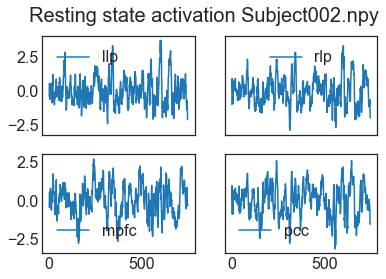

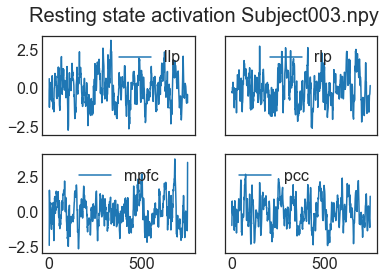

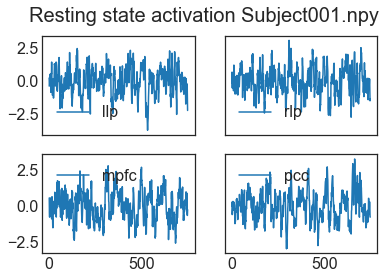

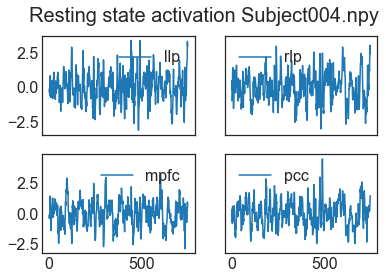

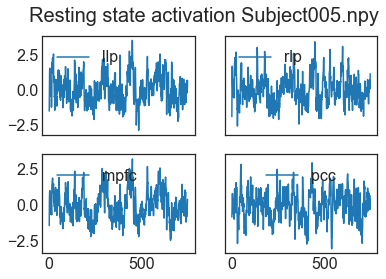

In [48]:
resultsCorr = None
for datafilename in datafilenames:
    if datafilename.endswith('.npy'):
        time_series = np.load(os.path.join(datadir,datafilename))
    else:
        continue
    mpfc = time_series[:,0]
    llp = time_series[:,1]
    rlp = time_series[:,2]
    pcc = time_series[:,3]
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    f.suptitle('Resting state activation '+datafilename)
    ax1.plot(llp, label="llp")
    ax1.legend()
    ax2.plot(rlp,label = "rlp")
    ax2.legend()
    ax3.plot(mpfc,label = "mpfc")
    ax3.legend()
    ax4.plot(pcc,label = "pcc")
    ax4.legend()
    
    print("mean MPFC: ",mpfc.mean())
    print("var: ",mpfc.std()**2)
    N=len(mpfc)
    print("N: ",N)
    mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc,0.802)
    print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
    print("A ",mpfc_A,"SD A",mpfc_sA)
    mpfc_norm=mpfc/np.sqrt(mpfc_A)
    t = np.arange(N)*0.802 # tR = 0.802 sec

    print("mean PCC: ",pcc.mean())
    print("var: ",pcc.std()**2)
    pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc,0.802)
    print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
    print("A ",pcc_A,"SD A",pcc_sA)
    pcc_norm=pcc/np.sqrt(pcc_A)
    
    print("mean RLP: ",rlp.mean())
    print("var: ",rlp.std()**2)
    rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp,0.802)
    print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
    print("A ",rlp_A,"SD A",rlp_sA)
    rlp_norm=rlp/np.sqrt(rlp_A)
    
    print("mean LLP: ",llp.mean())
    print("var: ",llp.std()**2)
    llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp,0.802)
    print("relaxation time:",llp_tau, "SD tau", llp_dtau)
    print("A ",llp_A,"SD A",llp_sA)
    llp_norm=llp/np.sqrt(llp_A)
    
    _,_,_,_,_,_,mpfc_pcc,mpfc_pcc_sd,_,_,_,_ = corrOU(mpfc_norm,pcc_norm,0.802)
    _,_,_,_,_,_,mpfc_rlp,mpfc_rlp_sd,_,_,_,_ = corrOU(mpfc_norm,rlp_norm,0.802)
    _,_,_,_,_,_,mpfc_llp,mpfc_llp_sd,_,_,_,_ = corrOU(mpfc_norm,llp_norm,0.802)
    _,_,_,_,_,_,pcc_rlp,pcc_rlp_sd,_,_,_,_ = corrOU(pcc_norm,rlp_norm,0.802)
    _,_,_,_,_,_,pcc_llp,pcc_llp_sd,_,_,_,_ = corrOU(pcc_norm,llp_norm,0.802)
    _,_,_,_,_,_,rlp_llp,rlp_llp_sd,_,_,_,_ = corrOU(rlp_norm,llp_norm,0.802)
    
    mpfc_pcc_pc,mpfc_pcc_pv = sps.pearsonr(mpfc_norm,pcc_norm)
    mpfc_rlp_pc,mpfc_rlp_pv = sps.pearsonr(mpfc_norm,rlp_norm)
    mpfc_llp_pc,mpfc_llp_pv = sps.pearsonr(mpfc_norm,llp_norm)
    pcc_rlp_pc,pcc_rlp_pv = sps.pearsonr(pcc_norm,rlp_norm)
    pcc_llp_pc,pcc_llp_pv = sps.pearsonr(pcc_norm,llp_norm)
    rlp_llp_pc,rlp_llp_pv = sps.pearsonr(rlp_norm,llp_norm)
    
    result = np.array([mpfc_pcc,
                       mpfc_pcc_sd,
                        mpfc_rlp,
                       mpfc_rlp_sd,
                        mpfc_llp,
                       mpfc_llp_sd,
                        pcc_rlp,
                       pcc_rlp_sd,
                        pcc_llp,
                       pcc_llp_sd,
                        rlp_llp,
                       rlp_llp_sd,
                        mpfc_pcc_pc,
                       mpfc_pcc_pv,
                        mpfc_rlp_pc,
                       mpfc_rlp_pv,
                        mpfc_llp_pc,
                       mpfc_llp_pv,
                        pcc_rlp_pc,
                       pcc_rlp_pv,
                        pcc_llp_pc,
                       pcc_llp_pv,
                        rlp_llp_pc,
                       rlp_llp_pv])
    
    if resultsCorr is None:
        resultsCorr = result
    else:
        resultsCorr = np.vstack((resultsCorr,result))
        

In [30]:
x = ['1','2','3','4','5','mean']
results.T[0]

array([3.03169143, 2.65864527, 1.2435271 , 0.94052167, 1.8311872 ])

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


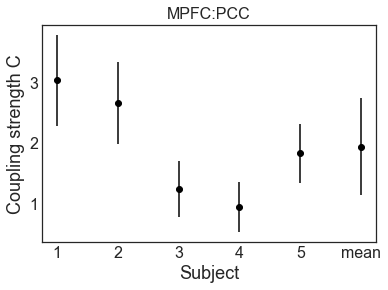

In [31]:
plt.errorbar(x,np.append(results.T[0],[results.T[0].mean()]),
                         yerr=np.append(results.T[1],[results.T[0].std()]),fmt="o",color="k")
plt.title("MPFC:PCC")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_pcc.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


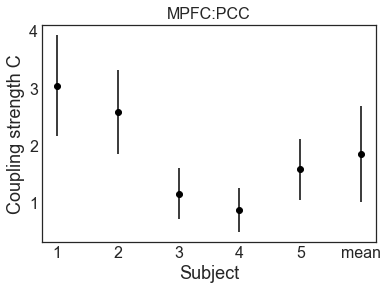

In [49]:
plt.errorbar(x,np.append(resultsCorr.T[0],[resultsCorr.T[0].mean()]),
                         yerr=np.append(resultsCorr.T[1]*3,[resultsCorr.T[0].std()]),fmt="o",color="k")
plt.title("MPFC:PCC")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_pccOU.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


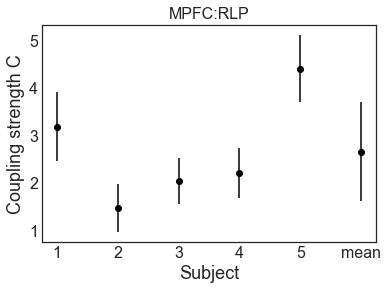

In [40]:
plt.errorbar(x,np.append(results.T[2],[results.T[2].mean()]),
                         yerr=np.append(results.T[3],[results.T[2].std()]),fmt="o",color="k")
plt.title("MPFC:RLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_rlp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


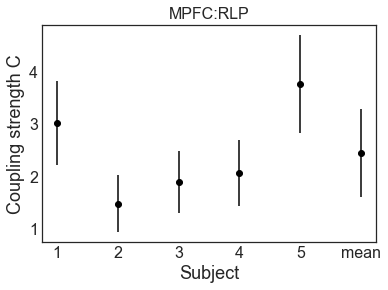

In [51]:
plt.errorbar(x,np.append(resultsCorr.T[2],[resultsCorr.T[2].mean()]),
                         yerr=np.append(resultsCorr.T[3]*3,[resultsCorr.T[2].std()]),fmt="o",color="k")
plt.title("MPFC:RLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_rlpOU.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


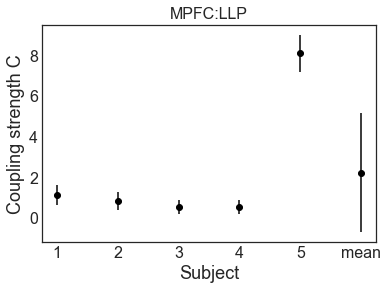

In [41]:
plt.errorbar(x,np.append(results.T[4],[results.T[4].mean()]),
                         yerr=np.append(results.T[5],[results.T[4].std()]),fmt="o",color="k")
plt.title("MPFC:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_llp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


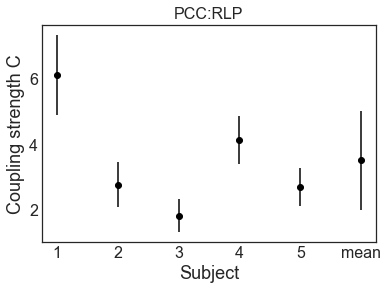

In [42]:
plt.errorbar(x,np.append(results.T[6],[results.T[6].mean()]),
                         yerr=np.append(results.T[7],[results.T[6].std()]),fmt="o",color="k")
plt.title("PCC:RLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("pcc_rlp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


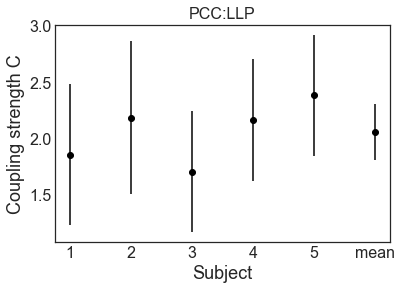

In [43]:
plt.errorbar(x,np.append(results.T[8],[results.T[8].mean()]),
                         yerr=np.append(results.T[9],[results.T[8].std()]),fmt="o",color="k")
plt.title("PCC:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("pcc_llp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


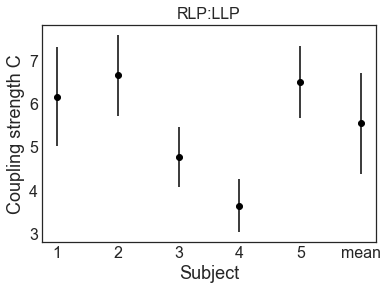

In [44]:
plt.errorbar(x,np.append(results.T[10],[results.T[10].mean()]),
                         yerr=np.append(results.T[11],[results.T[10].std()]),fmt="o",color="k")
plt.title("RLP:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("rlp_llp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
#np.savetxt(os.path.join(datadir,"results.csv"),results,delimiter = ",")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later


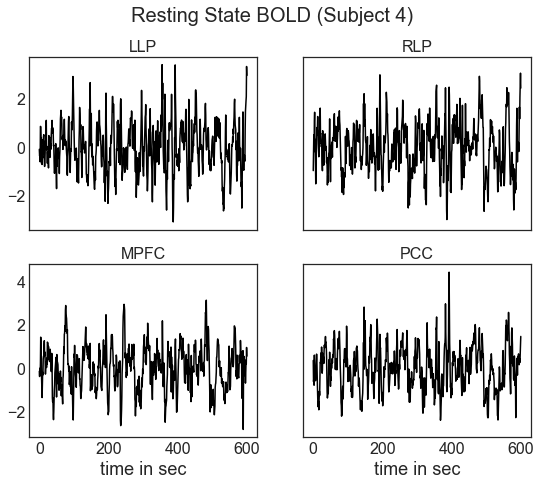

In [52]:
time_series = np.load(os.path.join(datadir,datafilenames[3]))
mpfc = time_series[:,0]
llp = time_series[:,1]
rlp = time_series[:,2]
pcc = time_series[:,3]
time = np.arange(len(llp))*0.802    
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(9,7))
f.suptitle('Resting State BOLD (Subject 4)')
ax1.plot(time,llp, label="llp",color="k")
ax1.set_title("LLP")
ax2.plot(time,rlp,label = "rlp",color="k")
ax2.set_title("RLP")
ax3.plot(time,mpfc,label = "mpfc",color="k")
ax3.set_title("MPFC")
ax3.set_xlabel("time in sec")
ax4.plot(time,pcc,label = "pcc",color="k")
ax4.set_title("PCC")
ax4.set_xlabel("time in sec")
plt.savefig("subject4.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
plotbins=20
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(9,7))
f.suptitle('Resting State BOLD (Subject 3)')
ax1.hist(llp,color="k",bins=plotbins,density=True,label="s=-0.34\nk=0.24")
ax1.set_title("LLP")
#ax1.legend()
ax2.hist(rlp,color="k",bins=plotbins,density=True,label="s=-0.00\nk=-0.16")
ax2.set_title("RLP")
#ax2.legend()
ax3.hist(mpfc,color="k",bins=plotbins,density=True,label="s=0.03\nk=-0.41")
ax3.set_title("MPFC")
#ax3.legend()
ax4.hist(pcc,color="k",bins=plotbins,density=True,label="s=0.18\nk=0.02")
ax4.set_title("PCC")
#ax4.legend()
plt.savefig("histogramsOT.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
print(skew(llp),kurtosis(llp))
print(skew(rlp),kurtosis(rlp))
print(skew(mpfc),kurtosis(mpfc))
print(skew(pcc),kurtosis(pcc))